In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

from xgboost import XGBClassifier
import optuna

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV
)
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    accuracy_score, precision_score,
    roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay, confusion_matrix
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load data for Tram
data = pd.read_csv("/Users/tbhuynh/Desktop/UNC_PHD/BIOS635/Final Project/train.csv")
submission = pd.read_csv("/Users/tbhuynh/Desktop/UNC_PHD/BIOS635/Final Project/test.csv")

In [78]:
# Load data for Ashley
data = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Final/train.csv")
submission = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Final/test.csv")

In [3]:
# Examine data
print(data.shape)
print(submission.shape)

# Calculate percentage of NaNs per column
nan_data = data.isna().mean() * 100

for col, i in nan_data.items():
    print(f"{col}: {i:.2f}% missing")
    
nan_submission = submission.isna().mean() * 100

for col, i in nan_submission.items():
    print(f"{col}: {i:.2f}% missing")

(140700, 20)
(93800, 19)
id: 0.00% missing
Name: 0.00% missing
Gender: 0.00% missing
Age: 0.00% missing
City: 0.00% missing
Working Professional or Student: 0.00% missing
Profession: 26.03% missing
Academic Pressure: 80.17% missing
Work Pressure: 19.84% missing
CGPA: 80.17% missing
Study Satisfaction: 80.17% missing
Job Satisfaction: 19.84% missing
Sleep Duration: 0.00% missing
Dietary Habits: 0.00% missing
Degree: 0.00% missing
Have you ever had suicidal thoughts ?: 0.00% missing
Work/Study Hours: 0.00% missing
Financial Stress: 0.00% missing
Family History of Mental Illness: 0.00% missing
Depression: 0.00% missing
id: 0.00% missing
Name: 0.00% missing
Gender: 0.00% missing
Age: 0.00% missing
City: 0.00% missing
Working Professional or Student: 0.00% missing
Profession: 26.26% missing
Academic Pressure: 79.99% missing
Work Pressure: 20.02% missing
CGPA: 79.99% missing
Study Satisfaction: 79.99% missing
Job Satisfaction: 20.01% missing
Sleep Duration: 0.00% missing
Dietary Habits: 0.01

In [4]:
# Drop id and Name
submission_ids = submission['id'].copy()
data.drop(['id', 'Name'], axis=1, inplace=True)
submission.drop(['id', 'Name'], axis=1, inplace=True)

# Handle sleep duration feature
def process_sleep_duration(sleep_value):
    try:
        if isinstance(sleep_value, str):
            # Handle "Less than 5 hours" and "More than 8 hours"
            if 'Less than 5 hours' in sleep_value:
                return 4.5
            if 'More than 8 hours' in sleep_value:
                return 9.0

            # Handle range cases like "6-7 hours" or "40-45 hours"
            if '-' in sleep_value and 'hours' in sleep_value:
                parts = sleep_value.split(' ')[0].split('-')
                a = float(parts[0])
                b = float(parts[1])
                avg = (a + b) / 2
                if a > 24 and b > 24:
                    return avg / 7  # weekly sleep range
                else:
                    return avg  # daily sleep range

            # Handle single number cases
            elif sleep_value.isdigit():
                value = float(sleep_value)
                if value > 24:
                    return value / 7  # weekly sleep
                else:
                    return value  # daily sleep

            # Handle messy or typos cases like 5-6hours if had
            elif 'hours' in sleep_value:
                num = sleep_value.split(' ')[0]
                if '-' in num:
                    parts = num.split('-')
                    a = float(parts[0])
                    b = float(parts[1])
                    avg = (a + b) / 2
                    if a > 24 and b > 24:
                        return avg / 7
                    else:
                        return avg
                else:
                    value = float(num)
                    if value > 24:
                        return value / 7
                    else:
                        return value
            else:
                return np.nan  # weird garbage entry
        else:
            return np.nan
    except:
        return np.nan


In [5]:
# Apply sleep duration processing
data['Sleep Duration Processed'] = data['Sleep Duration'].apply(process_sleep_duration)
submission['Sleep Duration Processed'] = submission['Sleep Duration'].apply(process_sleep_duration)

# Remove rows where Sleep Duration could not be processed
data = data[~data['Sleep Duration Processed'].isnull()]
#submission = submission[~submission['Sleep Duration Processed'].isnull()]

# Replace old Sleep Duration
data.drop(columns=['Sleep Duration'], inplace=True)
submission.drop(columns=['Sleep Duration'], inplace=True)
data.rename(columns={'Sleep Duration Processed': 'Sleep Duration'}, inplace=True)
submission.rename(columns={'Sleep Duration Processed': 'Sleep Duration'}, inplace=True)


In [6]:
# Drop heavily missing columns
drop_cols = ['Academic Pressure', 'CGPA', 'Study Satisfaction']
data.drop(columns=drop_cols, inplace=True)
submission.drop(columns=drop_cols, inplace=True)


In [7]:
# Add missing indicators for 20% missing values of features
for col in ['Work Pressure', 'Job Satisfaction']:
    new_col = f'is_{col.replace(" ", "_")}_missing'
    data[new_col] = data[col].isnull().astype(int)
    submission[new_col] = submission[col].isnull().astype(int)
    
# Fill moderate missing values with median
for col in ['Work Pressure', 'Job Satisfaction']:
    median = data[col].median()
    data[col].fillna(median, inplace=True)
    submission[col].fillna(median, inplace=True)


In [8]:
# Fill missing categorical values
data['Profession'].fillna('Unknown', inplace=True) # Profession has higher than 20% of missing 
submission['Profession'].fillna('Unknown', inplace=True)

In [9]:
# Small missing in submission
mode = submission['Dietary Habits'].mode()[0]
submission['Dietary Habits'].fillna(mode, inplace=True)

# Mapping
dietary_mapping = {
    # Healthy
    'Healthy': 'Healthy',
    'Yes': 'Healthy',
    'More Healthy': 'Healthy',
    '5 Healthy': 'Healthy',
    
    # Unhealthy
    'Unhealthy': 'Unhealthy',
    'No': 'Unhealthy',
    'No Healthy': 'Unhealthy',
    'Less Healthy': 'Unhealthy',
    'Less than Healthy': 'Unhealthy',
    '5 Unhealthy': 'Unhealthy',
    
    # Neutral
    'Moderate': 'Neutral'
}

# Apply mapping
data['Dietary Habits'] = data['Dietary Habits'].map(dietary_mapping).fillna('Other')
submission['Dietary Habits'] = submission['Dietary Habits'].map(dietary_mapping).fillna('Other')

from sklearn.preprocessing import LabelEncoder
# Label Encode binary categorical column
le = LabelEncoder()
data['Dietary Habits'] = le.fit_transform(data['Dietary Habits'])
submission['Dietary Habits'] = le.transform(submission['Dietary Habits'])

In [10]:
# Group rare observations into 'Other' so that we have less dummies -> better for one hot encoder
city_counts = data['City'].value_counts()
rare_cities = city_counts[city_counts < 100].index
data['City'] = data['City'].replace(rare_cities, 'Other')
submission['City'] = submission['City'].replace(submission['City'].value_counts()[submission['City'].value_counts() < 100].index, 'Other')

profession_counts = data['Profession'].value_counts()
rare_professions = profession_counts[profession_counts < 100].index
data['Profession'] = data['Profession'].replace(rare_professions, 'Other')
submission['Profession'] = submission['Profession'].replace(submission['Profession'].value_counts()[submission['Profession'].value_counts() < 100].index, 'Other')

degree_counts = data['Degree'].value_counts()
rare_degree = degree_counts[degree_counts < 100].index
data['Degree'] = data['Degree'].replace(rare_degree, 'Other')
submission['Degree'] = submission['Degree'].replace(submission['Degree'].value_counts()[submission['Degree'].value_counts() < 100].index, 'Other')

# One-hot encode multicategorical columns
data = pd.get_dummies(data, columns=['City', 'Profession', 'Degree', 'Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'])
submission = pd.get_dummies(submission, columns=['City', 'Profession', 'Degree', 'Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'])


In [11]:
print(data.isnull().sum()[data.isnull().sum() > 0])
print(submission.isnull().sum()[submission.isnull().sum() > 0])

Financial Stress    4
dtype: int64
Sleep Duration    8
dtype: int64


In [12]:
data['Financial Stress'].fillna(data['Financial Stress'].mode()[0], inplace=True)
submission['Sleep Duration'].fillna(submission['Sleep Duration'].mode()[0], inplace=True)

In [13]:
# Check
print(f"Number of rows with NaN in Train now: {data.isnull().any(axis=1).sum()}")    
print(f"Number of rows with NaN in Test now: {submission.isnull().any(axis=1).sum()}") 
print(data.shape)
print(submission.shape)

Number of rows with NaN in Train now: 0
Number of rows with NaN in Test now: 0
(140686, 114)
(93800, 113)


# Models

Model 1: XGBoost

In [18]:
# Run XGBoost

def tune_xgb_classifier(data_df):
    # 1. Prepare features and target
    X = data_df.drop('Depression', axis=1)
    y = data_df['Depression']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 2. Define Optuna objective
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
            'n_jobs': -1 # faster running
        }

        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return accuracy_score(y_test, preds)

    # 3. Run Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=25)

    # 4. Train best model
    best_model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss')
    best_model.fit(X_train, y_train)
    start_time = time.time()
    preds = best_model.predict(X_test)
    end_time = time.time()
    
    run_time = end_time - start_time

    return best_model, preds, run_time


In [19]:
xgb_model, xgb_preds, xgb_time = tune_xgb_classifier(data)

[I 2025-04-28 16:28:36,441] A new study created in memory with name: no-name-6cef983b-28a2-4c33-add9-87274f6a81f1
[I 2025-04-28 16:28:57,238] Trial 0 finished with value: 0.930128417760508 and parameters: {'n_estimators': 590, 'learning_rate': 0.011638828196126546, 'max_depth': 10, 'subsample': 0.8647042499275139, 'colsample_bytree': 0.6885552137269468, 'min_child_weight': 7, 'reg_lambda': 9.684841838379173, 'reg_alpha': 0.2868349176181532}. Best is trial 0 with value: 0.930128417760508.
[I 2025-04-28 16:29:12,924] Trial 1 finished with value: 0.9304601241529641 and parameters: {'n_estimators': 680, 'learning_rate': 0.026918642454565357, 'max_depth': 3, 'subsample': 0.730317050779747, 'colsample_bytree': 0.6169374603951188, 'min_child_weight': 3, 'reg_lambda': 0.1063850867532872, 'reg_alpha': 0.17323312694027637}. Best is trial 1 with value: 0.9304601241529641.
[I 2025-04-28 16:29:39,370] Trial 2 finished with value: 0.9300810311330142 and parameters: {'n_estimators': 970, 'learning_ra

[I 2025-04-28 16:35:40,952] Trial 22 finished with value: 0.930294270956736 and parameters: {'n_estimators': 610, 'learning_rate': 0.049630622445639816, 'max_depth': 3, 'subsample': 0.8600537941255924, 'colsample_bytree': 0.5063676768016968, 'min_child_weight': 2, 'reg_lambda': 4.956259287404956, 'reg_alpha': 0.16570740741792783}. Best is trial 6 with value: 0.9305312040942046.
[I 2025-04-28 16:35:55,558] Trial 23 finished with value: 0.9306259773491921 and parameters: {'n_estimators': 630, 'learning_rate': 0.05086916201463894, 'max_depth': 4, 'subsample': 0.8778177735776753, 'colsample_bytree': 0.5900705708329879, 'min_child_weight': 2, 'reg_lambda': 5.43766481224674, 'reg_alpha': 0.17800117945342245}. Best is trial 23 with value: 0.9306259773491921.
[I 2025-04-28 16:36:06,357] Trial 24 finished with value: 0.9303179642704829 and parameters: {'n_estimators': 430, 'learning_rate': 0.07247134609244855, 'max_depth': 4, 'subsample': 0.9351715952758111, 'colsample_bytree': 0.57889850527152

Model 2: k-NN

In [20]:
# Split into features and target
X = data.drop('Depression', axis=1)
y = data['Depression']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
# Cross validation to find best k
k_range = range(1, 16)
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy', verbose=2)
    cv_scores.append(scores.mean())

optimal_k = k_range[np.argmax(cv_scores)]
print(f"Optimal k: {optimal_k}, Accuracy: {max(cv_scores):.4f}")

# Train K-Nearest Neighbors classifier
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)

# Predict
start_time = time.time()
knn_preds = knn_model.predict(X_val)
end_time = time.time()

knn_time = end_time - start_time

[CV] END .................................................... total time=  21.9s
[CV] END .................................................... total time=  19.4s
[CV] END .................................................... total time=  21.0s
[CV] END .................................................... total time=  19.3s
[CV] END .................................................... total time=  11.3s
[CV] END .................................................... total time=  11.6s
[CV] END .................................................... total time=  13.1s
[CV] END .................................................... total time=  10.9s
[CV] END .................................................... total time=  10.5s


KeyboardInterrupt: 

Model 3: L1 Logistic Regression

In [104]:
# Grid search to find optimal tuning parameter, lambda
grid = {'C': np.logspace(-4, 4, 20)}
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
grid_search = GridSearchCV(lasso, grid, cv=5, scoring='accuracy', verbose=2)

# Get best model
grid_search.fit(X_train, y_train)
lasso_model = grid_search.best_estimator_
print("Best lambda (1/C):", 1 / grid_search.best_params_['C'])

# Make predictions
start_time = time.time()
lasso_preds = lasso_model.predict(X_val)
end_time = time.time()

lasso_time = end_time - start_time

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...........................................C=0.0001; total time=   0.4s
[CV] END ...........................................C=0.0001; total time=   0.3s
[CV] END ...........................................C=0.0001; total time=   0.3s
[CV] END ...........................................C=0.0001; total time=   0.3s
[CV] END ...........................................C=0.0001; total time=   0.3s
[CV] END ...........................C=0.00026366508987303583; total time=   0.5s
[CV] END ...........................C=0.00026366508987303583; total time=   0.5s
[CV] END ...........................C=0.00026366508987303583; total time=   0.4s
[CV] END ...........................C=0.00026366508987303583; total time=   0.5s
[CV] END ...........................C=0.00026366508987303583; total time=   0.4s
[CV] END ............................C=0.0006951927961775605; total time=   0.5s
[CV] END ............................C=0.000695

Model 4: Random Forest

In [50]:
# Grid search to find best model
rf = RandomForestClassifier(random_state=42)
grid = {'n_estimators': [10, 25, 50],     # num of trees
        'max_features': ['sqrt', 'log2']}   # num of predictors at each split

tune_rf = GridSearchCV(rf, grid, cv=5, scoring='accuracy', verbose=2)
tune_rf.fit(X_train, y_train)

# Get best model
rf_model = tune_rf.best_estimator_
rf_best_param = tune_rf.best_params_
print("Best parameters:", rf_best_param)

# Make predictions
start_time = time.time()
rf_preds = rf_model.predict(X_val)
end_time = time.time()

rf_time = end_time - start_time

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .................max_features=sqrt, n_estimators=10; total time=   1.8s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   1.5s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   1.7s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   2.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   1.9s
[CV] END .................max_features=sqrt, n_estimators=25; total time=   4.2s
[CV] END .................max_features=sqrt, n_estimators=25; total time=   4.3s
[CV] END .................max_features=sqrt, n_estimators=25; total time=   4.0s
[CV] END .................max_features=sqrt, n_estimators=25; total time=   4.4s
[CV] END .................max_features=sqrt, n_estimators=25; total time=   4.3s
[CV] END .................max_features=sqrt, n_estimators=50; total time=   8.6s
[CV] END .................max_features=sqrt, n_es

# Evaluation

In [25]:
# Evaluation results

def evaluate_model(name, y_true, y_pred, y_prob=None, time=None):
    print(f"\n📊  {name} Evaluation Metrics")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    if y_prob is not None:
        roc_auc = roc_auc_score(y_true, y_prob)
        print(f"ROC AUC  : {roc_auc:.4f}")
    else:
        roc_auc = None

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} ROC Curve")
        plt.legend()
        plt.grid()
        plt.show()

        # Precision-Recall Curve
        precs, recalls, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recalls, precs)
        plt.plot(recalls, precs, label=f"AUC = {pr_auc:.2f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{name} Precision-Recall Curve")
        plt.legend()
        plt.grid()
        plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Run Time (s)": time
    }

In [28]:
def train_eval_metrics(name, model, X_train, y_train):
    y_train_pred = model.predict(X_train)
    
    acc = accuracy_score(y_train, y_train_pred)
    prec = precision_score(y_train, y_train_pred)
    rec = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)
    
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
    }


📊  XGBoost Evaluation Metrics
Accuracy : 0.9307
Precision: 0.8133
Recall   : 0.8031
F1 Score : 0.8082
ROC AUC  : 0.9697


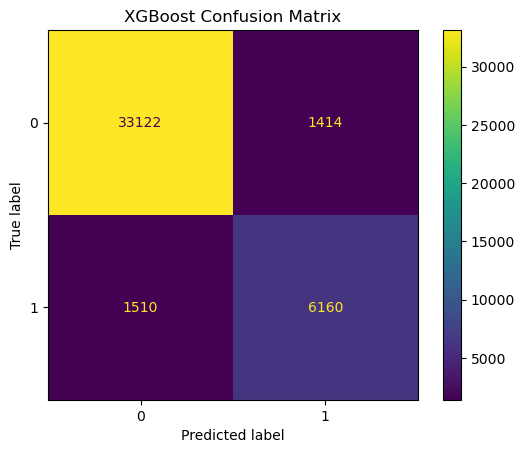

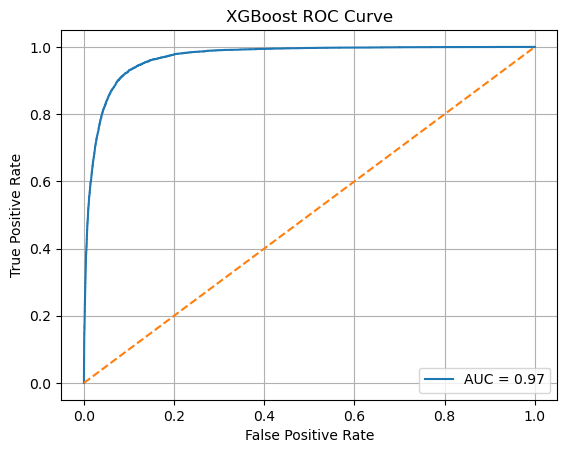

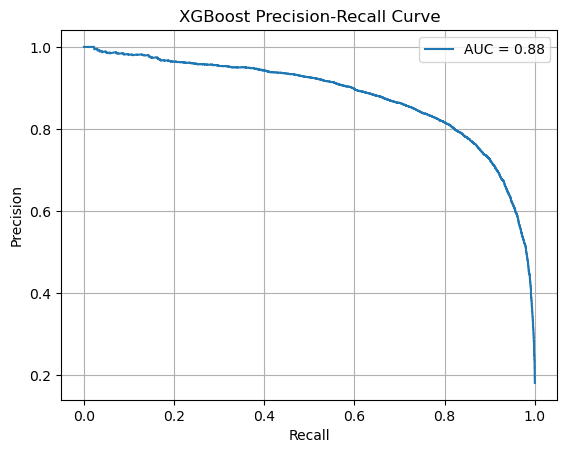


📊  KNN (k=14) Evaluation Metrics
Accuracy : 0.9221
Precision: 0.7983
Recall   : 0.7643
F1 Score : 0.7809
ROC AUC  : 0.9541


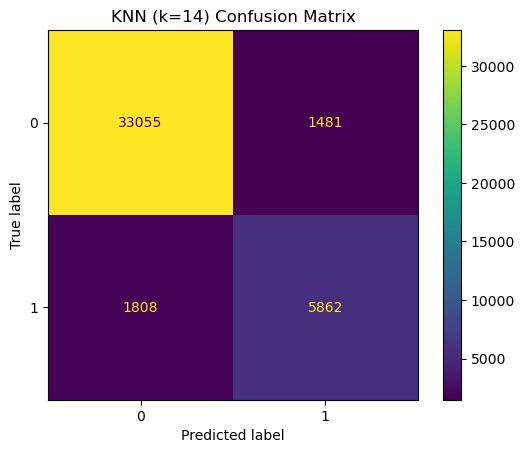

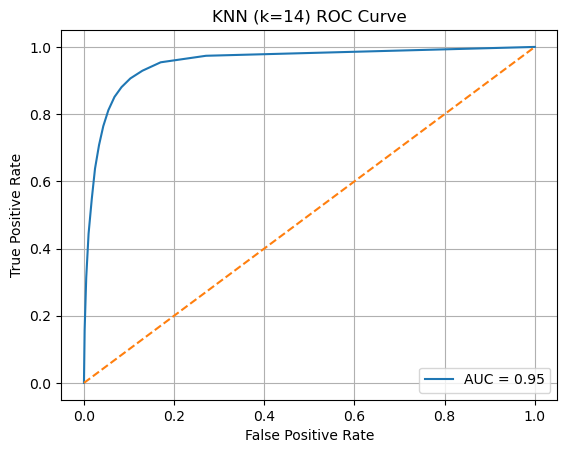

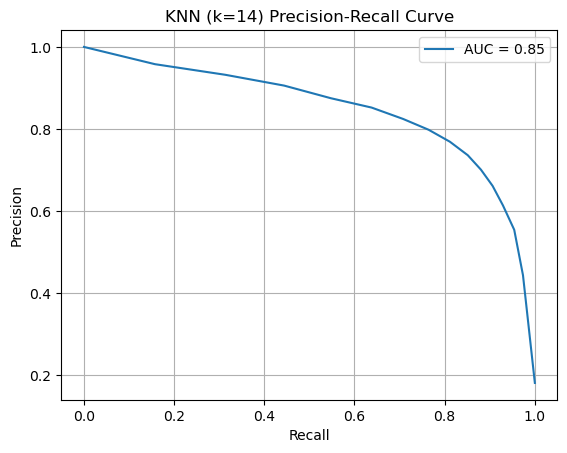


📊  Lasso Evaluation Metrics
Accuracy : 0.9297
Precision: 0.8157
Recall   : 0.7918
F1 Score : 0.8036
ROC AUC  : 0.9683


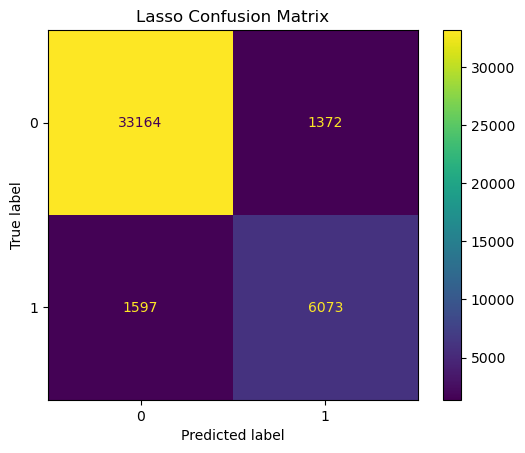

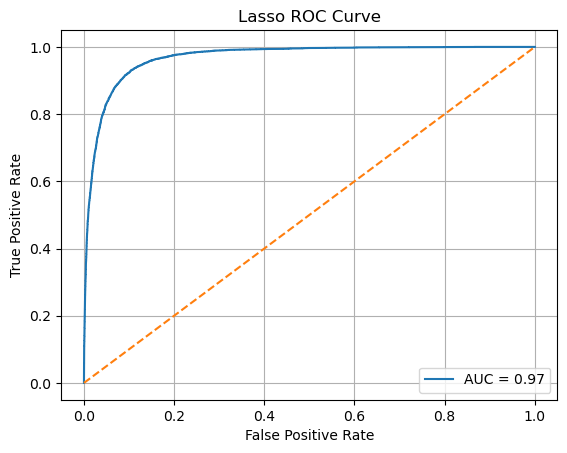

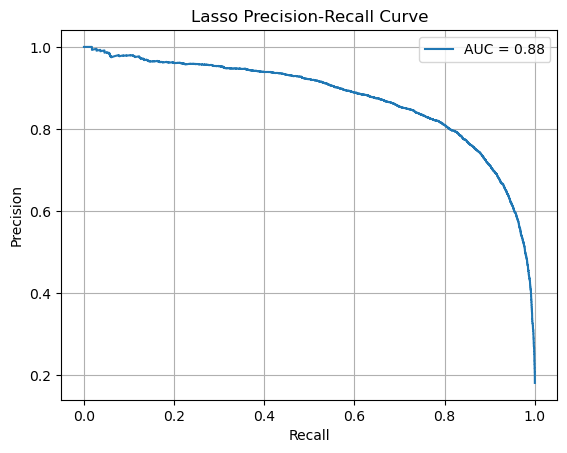


📊  Random Forest Evaluation Metrics
Accuracy : 0.9259
Precision: 0.8169
Recall   : 0.7634
F1 Score : 0.7892
ROC AUC  : 0.9635


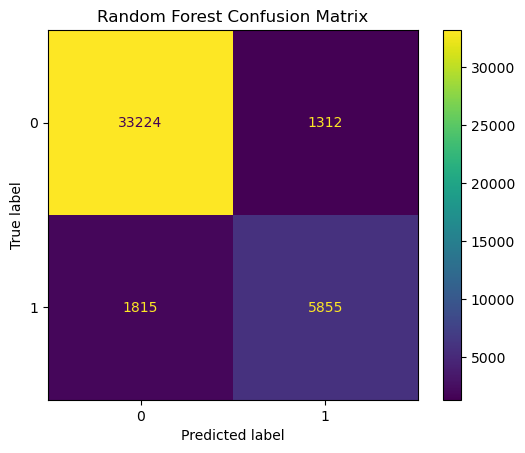

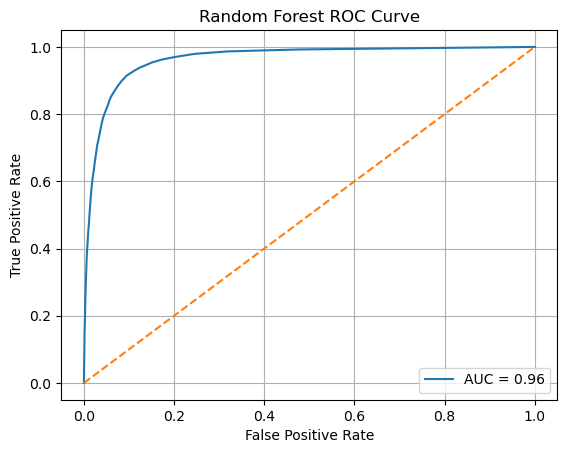

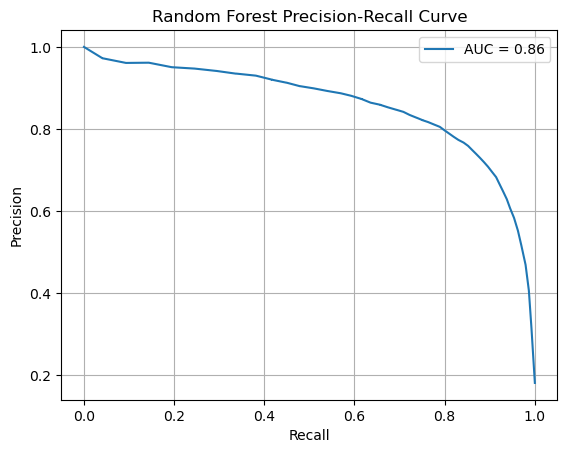


📋 Model Comparison Table on Test Set
           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0        XGBoost  0.930721   0.813309  0.803129  0.808187  0.969692   
1     KNN (k=14)  0.922073   0.798311  0.764276  0.780923  0.954100   
2          Lasso  0.929655   0.815715  0.791786  0.803573  0.968334   
3  Random Forest  0.925911   0.816939  0.763364  0.789243  0.963459   

   Run Time (s)  
0      0.202422  
1     20.301821  
2      0.118029  
3      0.590144  

 Model Comparision Table on Training Set
           Model  Accuracy  Precision    Recall  F1 Score
0        XGBoost  0.935449   0.826875  0.815556  0.821176
1     KNN (k=14)  0.931286   0.825362  0.788791  0.806663
2          Lasso  0.931286   0.821528  0.794491  0.807783
3  Random Forest  0.999878   0.999721  0.999609  0.999665


In [105]:
# Run evaluations for all 4 models
xgb_prob = xgb_model.predict_proba(X_val)[:, 1]
xgb_results = evaluate_model("XGBoost", y_val, xgb_preds, xgb_prob, xgb_time)
xgb_train_res = train_eval_metrics("XGBoost", xgb_model, X_train, y_train)

knn_prob = knn_model.predict_proba(X_val)[:, 1]
knn_results = evaluate_model(f"KNN (k={optimal_k})", y_val, knn_preds, knn_prob, knn_time)
knn_train_res = train_eval_metrics(f"KNN (k={optimal_k})", knn_model, X_train, y_train)

lasso_prob = lasso_model.predict_proba(X_val)[:, 1]
lasso_results = evaluate_model("Lasso", y_val, lasso_preds, lasso_prob, lasso_time)
lasso_train_res = train_eval_metrics("Lasso", lasso_model, X_train, y_train)

rf_prob = rf_model.predict_proba(X_val)[:, 1]
rf_results = evaluate_model("Random Forest", y_val, rf_preds, rf_prob, rf_time)
rf_train_res = train_eval_metrics("Random Forest", rf_model, X_train, y_train)

# Comparison table
comparison_df = pd.DataFrame([xgb_results, knn_results, lasso_results, rf_results])
print("\n📋 Model Comparison Table on Test Set")
print(comparison_df)

train_comparision_df = pd.DataFrame([xgb_train_res, knn_train_res, lasso_train_res, rf_train_res])
print("\n Model Comparision Table on Training Set")
print(train_comparision_df)

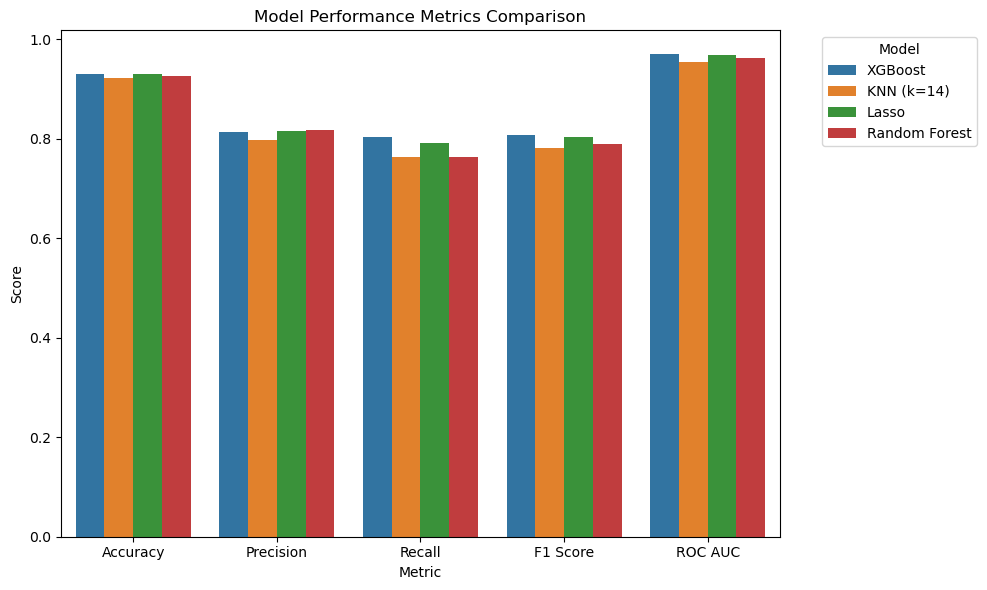

In [106]:
# Model comparison table as dataframe
df = pd.DataFrame(comparison_df)

# Make plot grouping metrics together 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
df_melted = df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Metrics Comparison')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

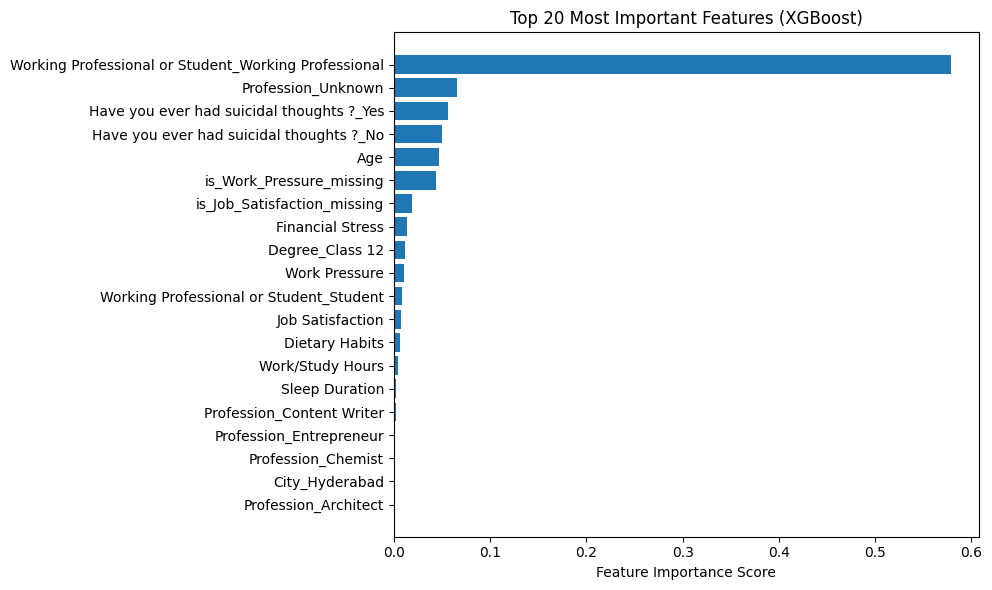

In [22]:
# Feature importance for XGBoost
importances = xgb_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1][:20]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()

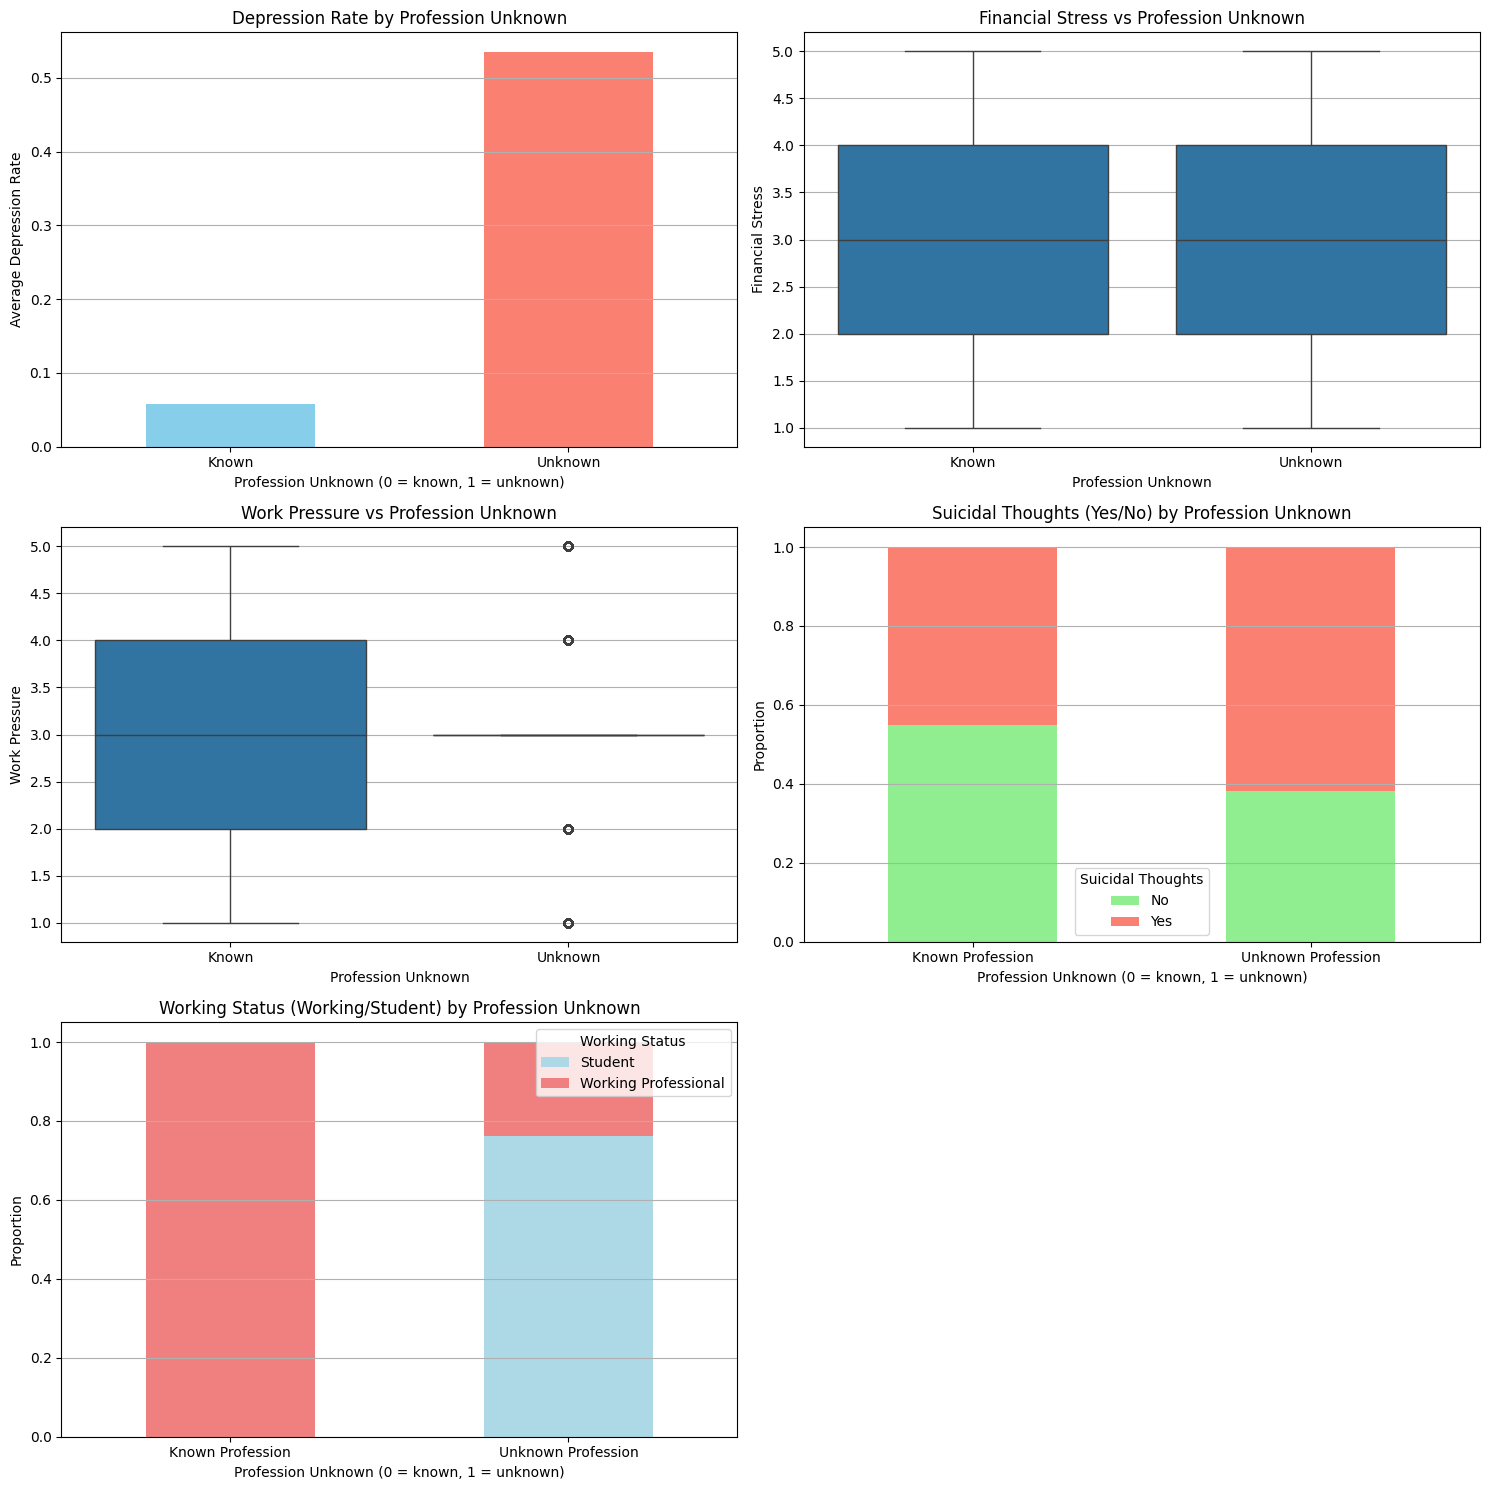

In [23]:
# Setup figure
fig, axes = plt.subplots(3, 2, figsize=(15, 15)) # 3 rows, 2 columns
axes = axes.flatten()  # Flatten to easily index axes

# Plot 1: Depression rate by Profession Unknown 
depression_rate_prof_unknown = data.groupby('Profession_Unknown')['Depression'].mean()
depression_rate_prof_unknown.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Depression Rate by Profession Unknown')
axes[0].set_xlabel('Profession Unknown (0 = known, 1 = unknown)')
axes[0].set_ylabel('Average Depression Rate')
axes[0].set_xticklabels(['Known', 'Unknown'], rotation=0)
axes[0].grid(axis='y')

# Plot 2: Financial Stress vs Profession Unknown 
sns.boxplot(x='Profession_Unknown', y='Financial Stress', data=data, ax=axes[1])
axes[1].set_title('Financial Stress vs Profession Unknown')
axes[1].set_xlabel('Profession Unknown')
axes[1].set_ylabel('Financial Stress')
axes[1].set_xticklabels(['Known', 'Unknown'])
axes[1].grid(axis='y')

# Plot 3: Work Pressure vs Profession Unknown 
sns.boxplot(x='Profession_Unknown', y='Work Pressure', data=data, ax=axes[2])
axes[2].set_title('Work Pressure vs Profession Unknown')
axes[2].set_xlabel('Profession Unknown')
axes[2].set_ylabel('Work Pressure')
axes[2].set_xticklabels(['Known', 'Unknown'])
axes[2].grid(axis='y')

# Plot 4: Suicidal Thoughts Rate by Profession Unknown 
ct_suicidal = pd.crosstab(data['Profession_Unknown'], data['Have you ever had suicidal thoughts ?_Yes'])
ct_suicidal = ct_suicidal.div(ct_suicidal.sum(axis=1), axis=0)
ct_suicidal.plot(kind='bar', stacked=True, ax=axes[3], color=['lightgreen', 'salmon'])  # plot to axes[3]
axes[3].set_title('Suicidal Thoughts (Yes/No) by Profession Unknown')
axes[3].set_xlabel('Profession Unknown (0 = known, 1 = unknown)')
axes[3].set_ylabel('Proportion')
axes[3].set_xticklabels(['Known Profession', 'Unknown Profession'], rotation=0)
axes[3].legend(['No', 'Yes'], title='Suicidal Thoughts')
axes[3].grid(axis='y')

# Plot 5: Depression rate by Working Status
ct_work = pd.crosstab(data['Profession_Unknown'], data['Working Professional or Student_Working Professional'])
ct_work = ct_work.div(ct_work.sum(axis=1), axis=0)
ct_work.plot(kind='bar', stacked=True, ax=axes[4], color=['lightblue', 'lightcoral'])  # plot to axes[4]
axes[4].set_title('Working Status (Working/Student) by Profession Unknown')
axes[4].set_xlabel('Profession Unknown (0 = known, 1 = unknown)')
axes[4].set_ylabel('Proportion')
axes[4].set_xticklabels(['Known Profession', 'Unknown Profession'], rotation=0)
axes[4].legend(['Student', 'Working Professional'], title='Working Status')
axes[4].grid(axis='y')

# Hide extra empty plot (axes[5]) 
fig.delaxes(axes[5])  # We have 5 plots but 6 spaces, remove last empty plot

# Layout adjustment
plt.tight_layout()
plt.show()


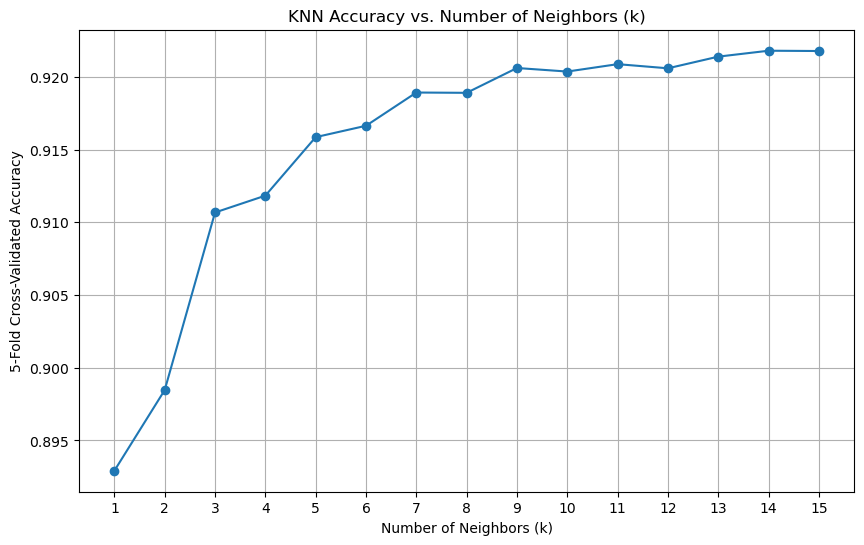

In [32]:
# Visual of selecting best k
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o')
plt.xticks(k_range)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("5-Fold Cross-Validated Accuracy")
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.grid(True)
plt.show()

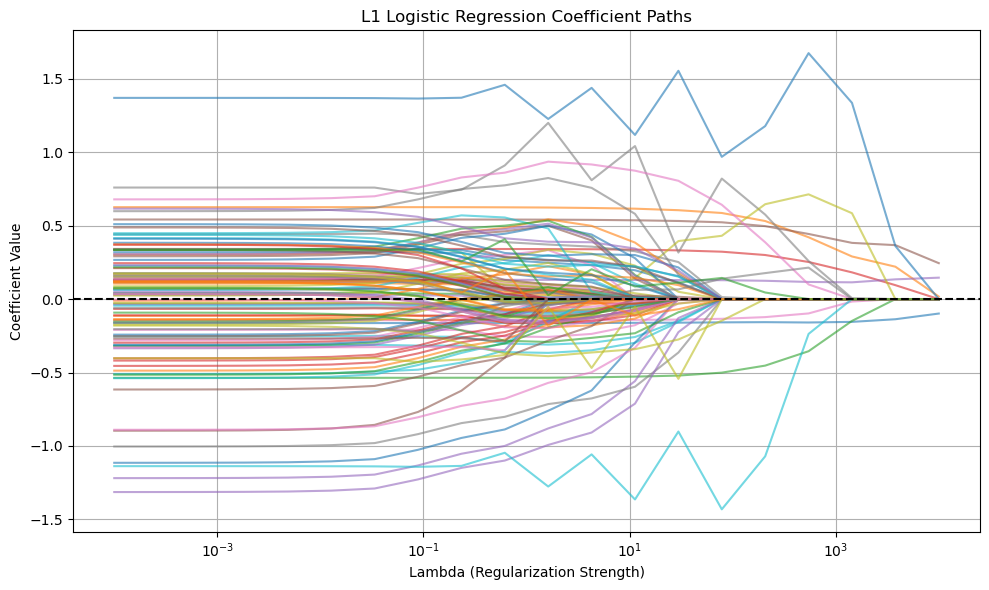

In [97]:
# Generate lambda values as the inverse of C
lambdas = 1 / np.logspace(-4, 4, 20)
coefs = []

# Fit the model for each value of C
for C in np.logspace(-4, 4, 20):
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42)
    model.fit(X_train, y_train)
    coefs.append(model.coef_[0])

coefs = np.array(coefs)

# Plotting the coefficient paths against lambda
plt.figure(figsize=(10, 6))
for i, coef_path in enumerate(coefs.T):
    plt.plot(lambdas, coef_path, label=X_train.columns[i], alpha=0.6)

plt.xscale("log")
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("L1 Logistic Regression Coefficient Paths")
plt.axhline(0, color='black', linestyle='--')
plt.grid()
plt.tight_layout()
plt.show()

In [98]:
# Selected features from final model
coefs_final = model.coef_[0]
selected_features = [i for i, c in enumerate(coefs_final) if c != 0]
selected_feature_names = [X_train.columns[i] for i in selected_features]
print(f"Number of features left in the model: {len(selected_feature_names)}")

Number of features left in the model: 113


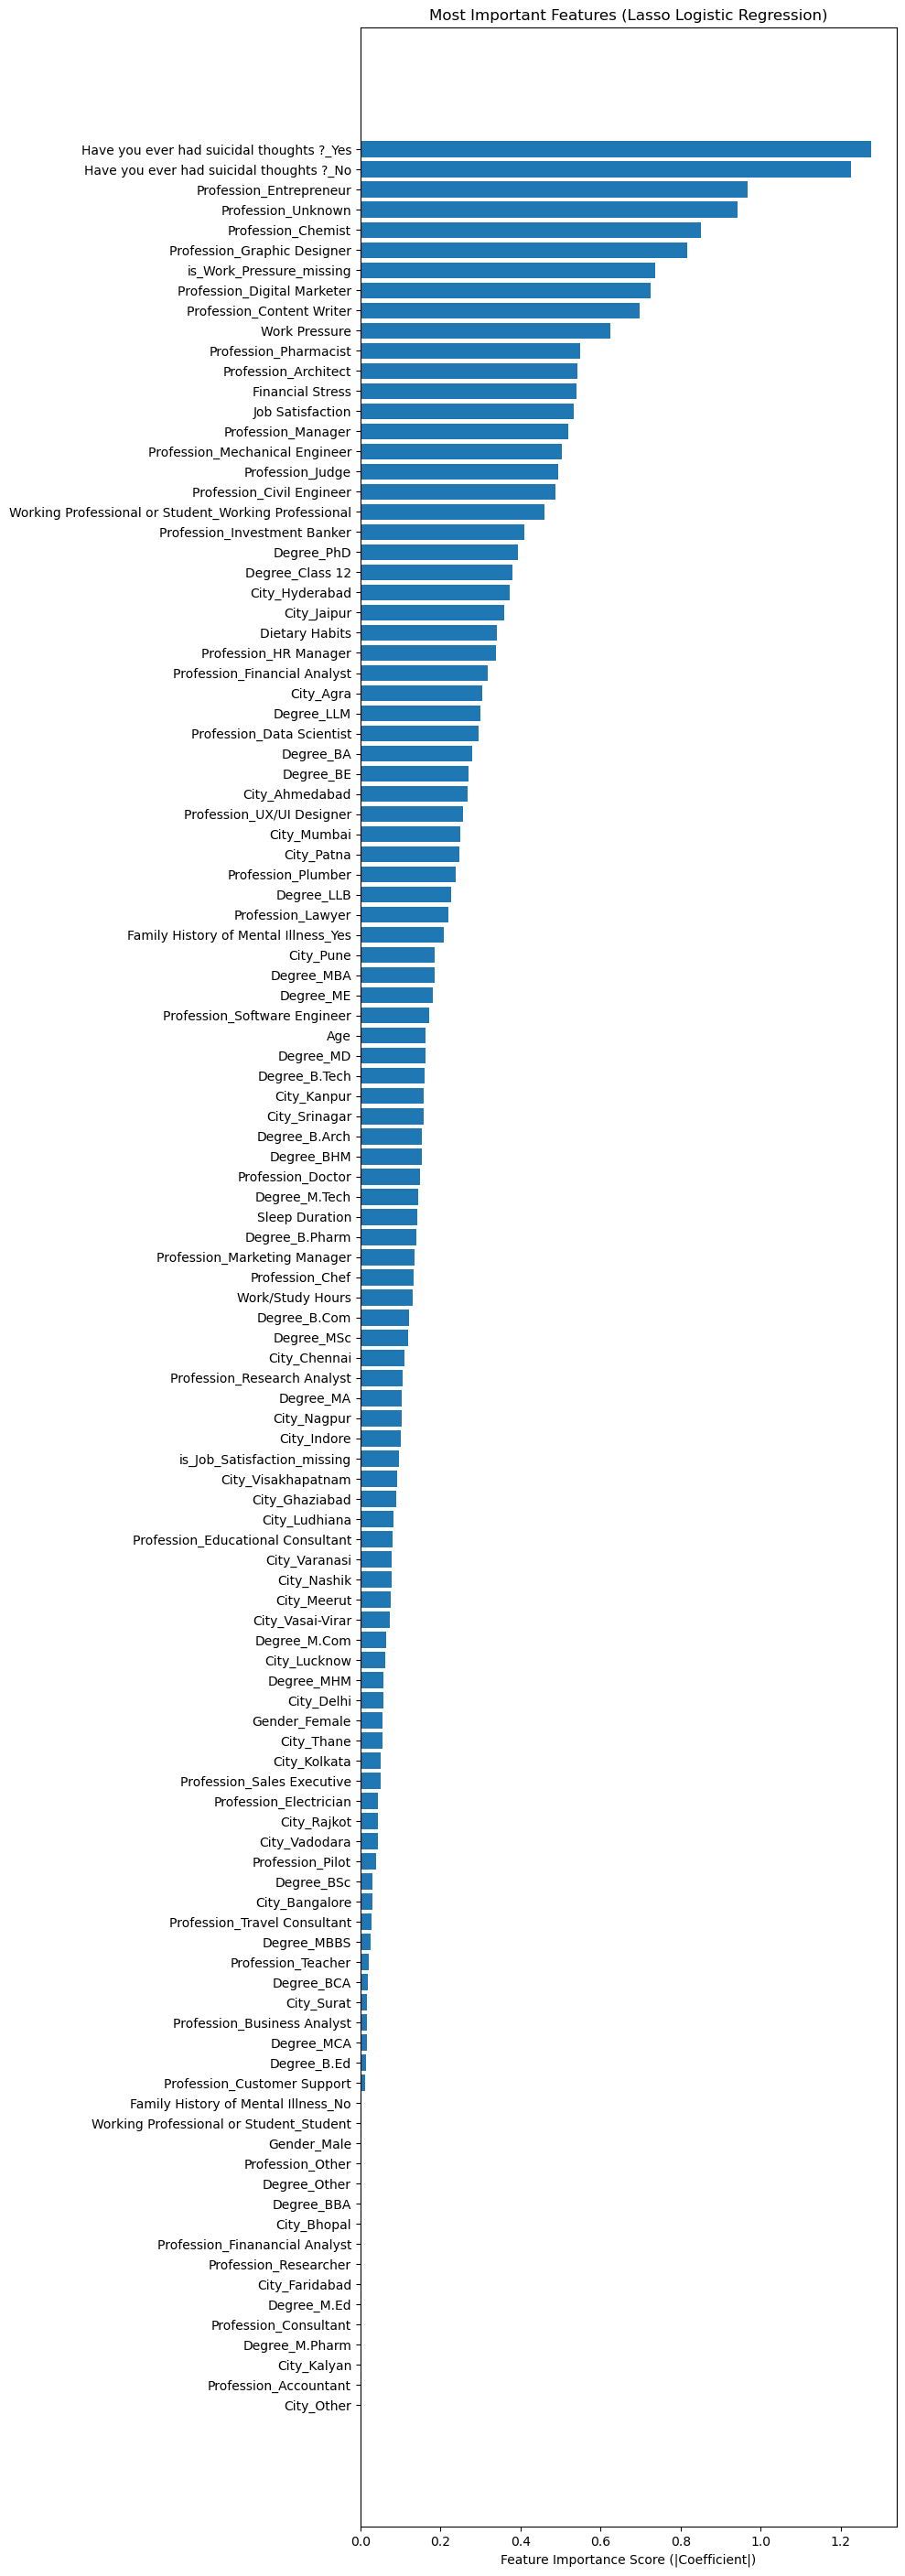

In [100]:
# Feature importance for Lasso (ALL)
lasso_importances = np.abs(lasso_model.coef_[0])  
sorted_idx = np.argsort(lasso_importances) 

plt.figure(figsize=(10, len(feature_names) * 0.25))  
plt.barh(range(len(sorted_idx)), lasso_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance Score (|Coefficient|)')
plt.title('Most Important Features (Lasso Logistic Regression)')
plt.tight_layout()
plt.show()

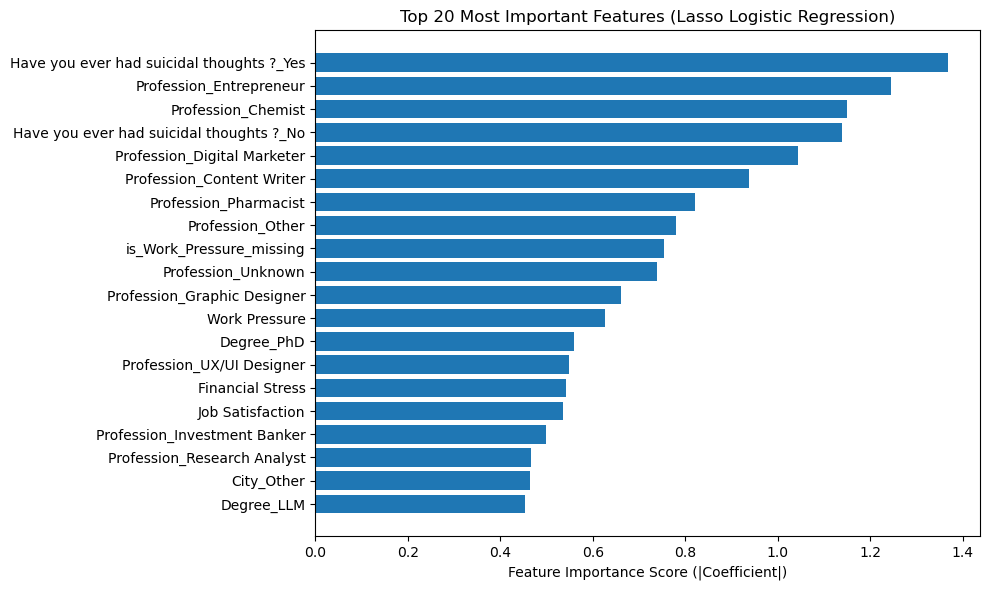

In [42]:
# Feature importance for Lasso
lasso_importances = np.abs(lasso_model.coef_[0]) 
sorted_idx = np.argsort(lasso_importances)[::-1][:20]  # Top 20

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), lasso_importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx][::-1])
plt.xlabel('Feature Importance Score (|Coefficient|)')
plt.title('Top 20 Most Important Features (Lasso Logistic Regression)')
plt.tight_layout()
plt.show()

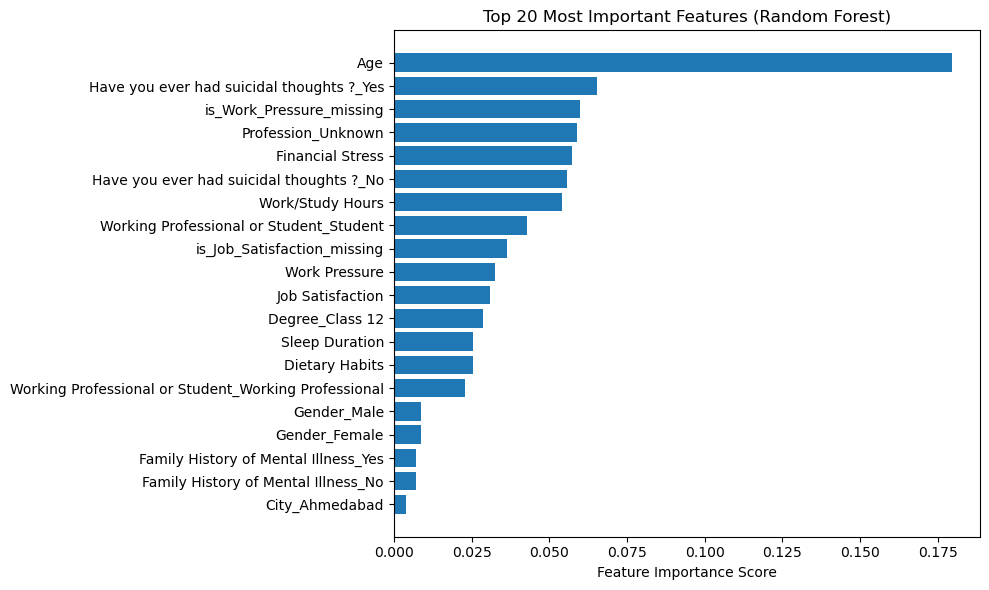

In [53]:
# Feature importance for Random Forest
rf_importances = rf_model.feature_importances_
sorted_idx = np.argsort(rf_importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), rf_importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

In [60]:
# Analyzing sparsity of dataset

true_counts = data.select_dtypes(include='bool').sum()
true_counts_sorted = true_counts.sort_values(ascending=False)

# Display full output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(true_counts_sorted)

Working Professional or Student_Working Professional    112799
Gender_Male                                              77464
Family History of Mental Illness_Yes                     69942
Have you ever had suicidal thoughts ?_Yes                69562
Profession_Teacher                                       61536
Dietary Habits_Moderate                                  49709
Dietary Habits_Unhealthy                                 46227
Dietary Habits_Healthy                                   44741
Sleep Duration_Less than 5 hours                         38784
Sleep Duration_7-8 hours                                 36969
Sleep Duration_More than 8 hours                         32726
Sleep Duration_5-6 hours                                 32142
Degree_Class 12                                          14731
Degree_B.Ed                                              11691
Degree_B.Arch                                             8742
Degree_B.Com                                           

# Prepare submission file

In [88]:
# Count the number of missing values
missing_values_count = submission.isnull().sum()
total_missing_values = missing_values_count.sum()

print(f"Total missing values in the dataset: {total_missing_values}")

# Match the columns of submission to the columns of data
submission = submission[X.columns]

Total missing values in the dataset: 8


In [89]:
submission_y = xgb_model.predict(submission)

In [90]:
df = pd.DataFrame({
    'id': submission_ids,
    'Depression': submission_y
})

# Export the DataFrame to a CSV file
df.to_csv('submission.csv', index=False)

print("CSV file has been saved.")

CSV file has been saved.
